In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---
## Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if I say the drone is at $(x,y,z)$ I mean that it is in the box centered at $(x,y,z)$. And there are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. So, for example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, which is just a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, which is a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the heck that landing pad is, and how to get there from any initial state.

In [2]:
class MDPLanding:
    def __init__(self, L, default_reward, discount):
        # states represent all positions in a 3D box
        self.states = [(x,y,z) for x in range(0,L+1) for y in range(0,L+1) for z in range(0,L+1)]
        # terminal states are all states where z = 0 (ground)
        self.terminalStates = [(x,y,0) for x in range(0,L+1) for y in range(0,L+1)]
        self.defaultReward = default_reward
        self.discount = discount
        self.L = L
    
    def actions(self, state):
        actions = []
        # trys going down first because the bottom is where all the valuable info is
        if (state[0], state[1], state[2]-1) in self.states: # Down
            actions.append((state[0], state[1], state[2]-1))
        if (state[0]+1, state[1], state[2]) in self.states: # East
            actions.append((state[0]+1, state[1], state[2]))
        if (state[0]-1, state[1], state[2]) in self.states: # West
            actions.append((state[0]-1, state[1], state[2]))
        if (state[0], state[1]+1, state[2]) in self.states: # North
            actions.append((state[0], state[1]+1, state[2]))
        if (state[0], state[1]-1, state[2]) in self.states: # South
            actions.append((state[0], state[1]-1, state[2]))
        if (state[0], state[1], state[2]+1) in self.states: # Up
            actions.append((state[0], state[1], state[2]+1))
        return actions
    
    def reward(self, state):
        if state in self.terminalStates:
            # landing pad
            if state == (self.L/2, self.L/2, 0): return 1
            # wrong ground location
            else: return -1
        # anywhere in the air
        else: return -0.01
        
    def randomNonTerminalState(self):
        s = (0,0,0)
        while s in self.terminalStates:
            s = self.states[np.random.choice(len(self.states))]
        return s

#### Part B

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values (see Section 22.3 in the textbook - page 803 might be of particular interest).  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. I refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [3]:
import time

def QlearningAlgo(env, episodes):
    # initialize Q and N dicts and cumulative reward list
    Q = {}
    N = {}
    cumulativeReward = []
    
    # fill all dictionary values with 0
    for initS in env.states:
        for initA in env.actions(initS):
            Q[initS,initA] = 0
            N[initS,initA] = 0
    
    # run episodes
    for e in range(episodes):
        
        # extend cumulativeReward list
        cumulativeReward.append(0)
        
        # generate random state that is not a terminal state
        s = env.randomNonTerminalState()

        # run episode for 50 time steps
        start = time.time()
        timeSteps = 50
        while time.time() < start + timeSteps:
            
            # pick best action from s based on Q values
            # effectively moves the drone into state a
            bestQ = -np.inf
            for action in env.actions(s):
                if Q[s,action] > bestQ:
                    bestQ = Q[s,action]
                    a = action

            # calcluate exploratory motivator:
            # increment number of visits to state a from state s.
            # explore decreases as N[s,a] increases.
            # explore provides a consequence for visiting states many times.
            N[s,a] += 1
            explore = 1 / N[s,a]

            # find maximum Q value in current state a's actions
            # how good of a position is the drone now in?
            bestNextQ = -np.inf 
            for aPrime in env.actions(a):
                bestNextQ = max(bestNextQ, Q[a,aPrime])

            # update Q value:
            # (previous value of moving from s to a) + (the new learned value of moving from s to a)
            Q[s,a] = Q[s,a] + explore * (env.reward(a) + (env.discount * bestNextQ) - Q[s,a])

            # record ammount of time passed in this episode
            currentTimeStep = time.time() - start
            
            # cumulative reward = discount * the reward of the current state
            # as currentTimeStep increases, the discount will decrease which will decrease reward more.
            # as time passes, the rewards become more discounted. achieving goal sooner is more valuble than later. pretty cool.
            cumulativeReward[e] += (env.discount**currentTimeStep) * env.reward(a)
            
            # if drone is in a terminal state (landed), episode is over
            if a in env.terminalStates:
                break
            
            # if drone still flying, set s to a and do it all over again
            s = a
    
    # return dict of Q values and list of cumulative rewards for each episode
    return Q,cumulativeReward

Creating environment and runnning the Q learning algo to train the drone:

In [4]:
# creating environment
env = MDPLanding(L = 10, default_reward = -0.01, discount = .999)

# using algorithm to train drone (this will take about 20 seconds)
droneReportCard = QlearningAlgo(env = env, episodes = 5000)

#### Part C

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your codes.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.1 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

Mean of last 5000 trials cumulative rewards:  0.7657378736280803


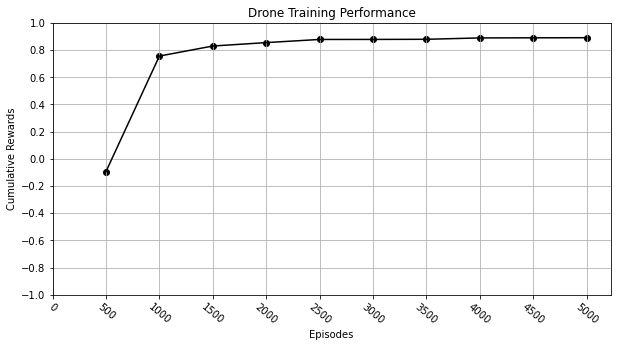

In [5]:
print('Mean of last 5000 trials cumulative rewards: ', np.mean(droneReportCard[1]))

blockMeans = np.array([])
episodes = np.array([])

for i in range(0, 5000, 500):
    blockMeans = np.append(blockMeans, np.mean(droneReportCard[1][i : i+499]))
    episodes = np.append(episodes, i+500)

df = pd.DataFrame(data=blockMeans, columns=['Cumulative Rewards'])
df['Episodes'] = episodes
df.head()

df.plot(x ='Episodes', y='Cumulative Rewards', kind = 'line', color = 'black')
plt.scatter(x = df['Episodes'], y= df['Cumulative Rewards'], color = 'black')
plt.title('Drone Training Performance')
plt.ylabel('Cumulative Rewards')
plt.grid(True)
plt.xticks(np.arange(0, 5500, 500), rotation=-40)
plt.yticks(np.arange(-1, 1.2, .2))
plt.gcf().set_size_inches(10, 5)
plt.legend().remove()
plt.show()